In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import random

2024-06-24 20:23:33.423362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 20:23:33.423529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 20:23:33.600542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# dataframed = pd.DataFrame(columns = ['path', 'label', 'scene_id', 'longitude', 'latitude'])
# scenes = pd.DataFrame(columns = ['path', 'label'])

In [4]:
# dataframes = [dataframed]
# for x in range(0, len(dataframes)):
#     temp = '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/'
#     for dirname, _, filenames in os.walk(temp) :
#             for filename in filenames :
#                 path = os.path.join(dirname, filename)
#                 name = filename
#                 splitter = name.split('_')
#                 path = os.path.join(dirname, filename)
#                 label = int(splitter[0])
#                 scene_id = splitter[2] + '_' + splitter[3] + '_' + splitter[4]
#                 longitude = splitter[6]
#                 latitude = splitter[7].rstrip('.png')
#                 dataframes[x].loc[len(dataframes[x])] = [temp + '/' + name, label, scene_id, longitude, latitude]

In [5]:
path = "/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/"

# Generate a list of files for ship and no_ship files
noship = glob(os.path.join(path, "0_*"))
ship = glob(os.path.join(path, "1_*"))

# Open the files
images = []
labels = []
imagespath = []
labelsname = ['No ship', 'Ship']

for file in noship:
    img_path = os.path.join(path, file) 
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(0)
    imagespath.append(img_path)
    
for file in ship:
    img_path = os.path.join(path, file) 
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(1)
    imagespath.append(img_path)

    
images = np.array(images, dtype=np.int64)
labels = np.array(labels, dtype=np.int64)
imagespath = np.array(imagespath)

In [6]:
np.random.seed(19)
np.random.shuffle(images)
np.random.seed(19)
np.random.shuffle(labels)
np.random.seed(19)
np.random.shuffle(imagespath)

In [7]:
print(imagespath)

['/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170508_180612_1010__-122.42206174502493_37.72288112534968.png'
 '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170730_191230_0f21__-122.10549691828378_37.76946626247702.png'
 '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170822_153738_0c12__-118.1826009458025_33.71029030037845.png'
 ...
 '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20180708_180453_0f28__-118.27748077799673_33.7862635343534.png'
 '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170211_181115_0e16__-122.31192343387383_37.75754911839131.png'
 '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170909_181729_0e0f__-122.37813391674946_37.79782712816502.png']


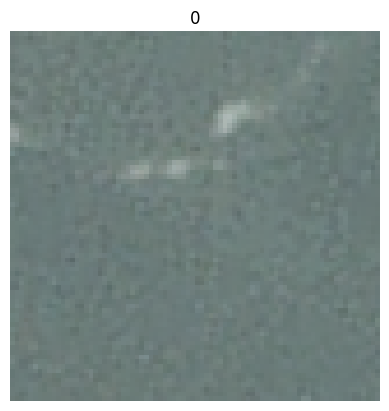

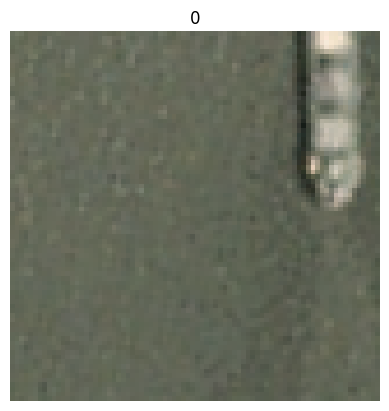

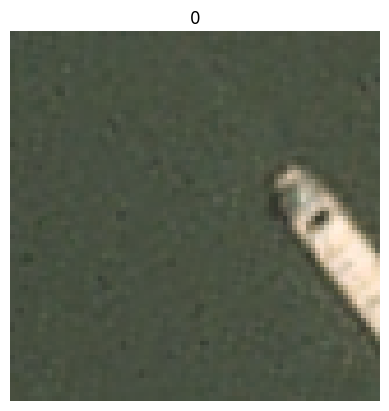

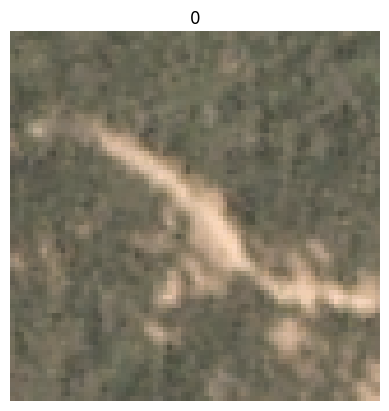

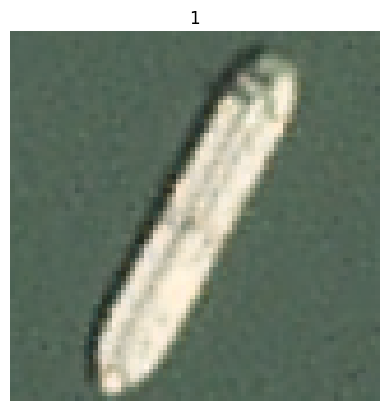

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # Required to open images

# Set the number of random images you want to display
num_images = 5
np.random.seed(23)
# Randomly select `num_images` paths from imagespath
random_indices = np.random.choice(len(imagespath), num_images, replace=False)
random_image_paths = imagespath[random_indices]
random_labels = labels[random_indices]

def open_and_display_image(image_path, label):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(label)  # Set the title as the label
    plt.axis('off')
    plt.show()

# Display each random image with its label
for image_path, label in zip(random_image_paths, random_labels):
    open_and_display_image(image_path, label)

In [9]:
# dataframes = [scenes] 
# for x in range(0, len(dataframes)):
#     temp = '/kaggle/input/ships-in-satellite-imagery/scenes/scenes/'
#     for dirname, _, filenames in os.walk(temp) :
#             for filename in filenames :
#                 path = os.path.join(dirname, filename)
#                 name = filename
#                 path = os.path.join(dirname, filename)
#                 dataframes[x].loc[len(dataframes[x])] = [temp + '/' + name, filename]

In [10]:
# dataframed.head()

In [11]:
# scenes.head()

In [12]:
import cv2
import numpy as np
import pandas as pd

def size_regulator(df, image_column='path', target_size=(80, 80)):
    images = []
    for path in df[image_column]:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        image = cv2.resize(image, target_size)  
        images.append(image)
    return np.array(images)

In [13]:
train_size = int(len(images)*.7)
validation_size = int(len(images)*.2)
test_size = int(len(images)*.1)

In [14]:
train_size+validation_size+test_size

4000

In [15]:
len(images)

4000

In [16]:
X_train, y_train = images[:train_size], labels[:train_size]
X_validation, y_validation = images[train_size:(validation_size+train_size)], labels[train_size:(validation_size+train_size)]
X_test, y_test = images[(validation_size+train_size):], labels[(validation_size+train_size):]

In [17]:
ye_train = to_categorical(y_train, num_classes=2)
ye_validation = to_categorical(y_validation, num_classes=2)
ye_test = to_categorical(y_test, num_classes=2)

In [18]:
ye_test[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [19]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(dataframed, test_size=0.2, random_state = 42)

In [20]:
# X_Train = size_regulator(train)
# X_Test = size_regulator(test)

In [21]:
# y_Train = train
# y_Test = test
# y_Train = y_Train.drop(['path', 'scene_id', 'longitude', 'latitude'], axis=1)
# y_Test = y_Test.drop(['path', 'scene_id', 'longitude', 'latitude'], axis=1)

In [22]:
# y_Train.head()

In [23]:
# y_Test.head()

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Resizing
from tensorflow.keras.models import Sequential

# Define the Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape = (80, 80, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2)))
    
    # Flatten to connect to fully connected layers
model.add(Flatten())

    # Dense layers for classification
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Assuming 7 classes for classification


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,666,754 (13.99 MB)

 Trainable params: 3,666,754 (13.99 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# X_Train = X_Train.reshape(-1, 80, 80, 1)
# y_Train = np.array(y_Train)


# X_Test = X_Test.reshape(-1, 80, 80, 1)
# y_Test_np = np.array(y_Test)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("ship_detection.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, ye_train, batch_size=16, epochs=15, verbose=1, validation_data=(X_validation, ye_validation), callbacks=[checkpoint])

Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8097 - loss: 16.8386
Epoch 1: val_accuracy improved from -inf to 0.90500, saving model to ship_detection.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.8100 - loss: 16.7647 - val_accuracy: 0.9050 - val_loss: 0.2291
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9273 - loss: 0.1883
Epoch 2: val_accuracy improved from 0.90500 to 0.94250, saving model to ship_detection.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.9274 - loss: 0.1881 - val_accuracy: 0.9425 - val_loss: 0.1340
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9728 - loss: 0.0860
Epoch 3: val_accuracy improved from 0.94250 to 0.98250, saving model to ship_detection.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.9728 - loss: 0.0860 - val_accuracy: 0.9825 - val_loss: 0.0499
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9789 - loss: 0.0632
Epoch 4: v

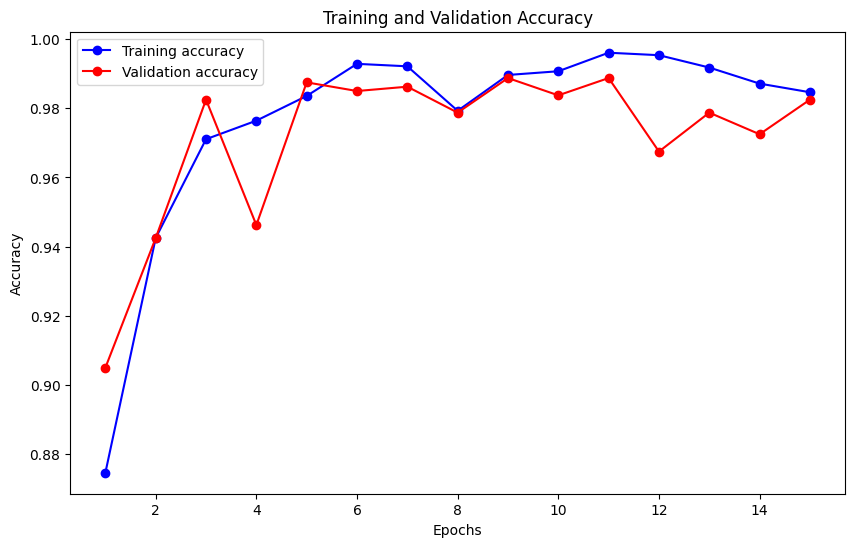

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
def calculate_dimensions(image, threshold=127):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Morphological operations to improve segmentation
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours are found, return zero dimensions
    if not contours:
        return 0, 0
    
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calculate the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Return width and height
    return h, w


In [29]:
def classify_ship(length, width):
    # Simple classification based on dimensions
    if length > 100 and width > 50:
        return 'A'
    elif length > 80 and width > 40:
        return 'B'
    elif length > 60 and width > 30:
        return 'C'
    elif length > 40 and width > 20:
        return 'D'
    else:
        return 'E'

Image: /kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170508_180612_1010__-122.42206174502493_37.72288112534968.png
Dimensions (Length x Width): [80 36]
Class: C
------------
Image: /kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170730_191230_0f21__-122.10549691828378_37.76946626247702.png
Dimensions (Length x Width): [80 80]
Class: C
------------
Image: /kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170822_153738_0c12__-118.1826009458025_33.71029030037845.png
Dimensions (Length x Width): [53 12]
Class: E
------------
Image: /kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170910_181216_1010__-122.39515136904267_37.72923562830778.png
Dimensions (Length x Width): [80 80]
Class: C
------------
Image: /kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20180712_180428_101b__-118.14229283066219_33.736967999190405.png
Dimensions (Length x Width): [49 37]
Class: D
------------
Image: /kaggle/input/ships-in-satellite-

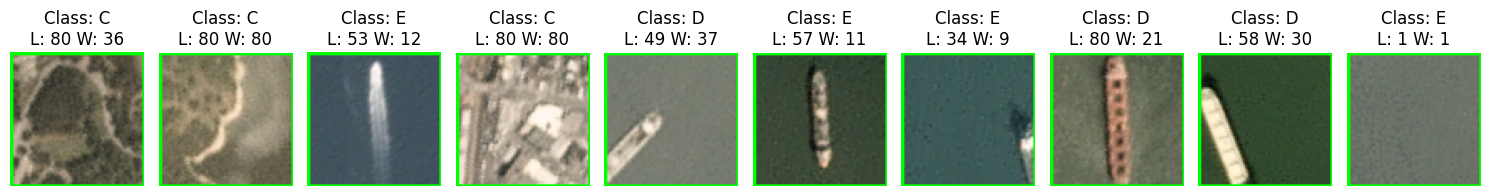

In [30]:
image_dimensions = []
image_classes = []

for image_path in imagespath:
    image = cv2.imread(image_path)
    if image is None:
        continue  # Skip if the image is not found or cannot be read
    length, width = calculate_dimensions(image)
    ship_class = classify_ship(length, width)
    
    image_dimensions.append((length, width))
    image_classes.append(ship_class)

# Convert to numpy arrays for further processing if needed
image_dimensions = np.array(image_dimensions)
image_classes = np.array(image_classes)

# Set the number of images to display
num_images_to_display = 10  # Change this number to display more or fewer images

# Example to show the dimensions and classes
for i, image_path in enumerate(imagespath[:num_images_to_display]):
    print(f"Image: {image_path}")
    print(f"Dimensions (Length x Width): {image_dimensions[i]}")
    print(f"Class: {image_classes[i]}")
    print("------------")

# Visualization of images with their dimensions and class
plt.figure(figsize=(15, 10))
for idx in range(num_images_to_display):  # Display specified number of images
    image = cv2.imread(imagespath[idx])
    if image is None:
        continue
    length, width = image_dimensions[idx]
    ship_class = image_classes[idx]
    
    # Draw bounding box for visualization
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    _, thresh = cv2.threshold(image_gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    plt.subplot(1, num_images_to_display, idx + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Class: {ship_class}\nL: {length} W: {width}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [31]:
imagespath

array(['/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170508_180612_1010__-122.42206174502493_37.72288112534968.png',
       '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170730_191230_0f21__-122.10549691828378_37.76946626247702.png',
       '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170822_153738_0c12__-118.1826009458025_33.71029030037845.png',
       ...,
       '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20180708_180453_0f28__-118.27748077799673_33.7862635343534.png',
       '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170211_181115_0e16__-122.31192343387383_37.75754911839131.png',
       '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170909_181729_0e0f__-122.37813391674946_37.79782712816502.png'],
      dtype='<U128')

In [32]:
real_image_path = '/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20180707_182443_0f17__-122.35847178421098_37.793936209972244.png'  # Replace with actual path
real_image = cv2.imread(real_image_path)
real_image = cv2.cvtColor(real_image, cv2.COLOR_BGR2RGB)
real_image_resized = cv2.resize(real_image, (80, 80))
real_image_resized = np.expand_dims(real_image_resized, axis=0)

prediction = model.predict(real_image_resized)
predicted_label = np.argmax(prediction)

if predicted_label == 1:  # Ship detected
    length, width = calculate_dimensions(real_image_resized[0])
    ship_class = classify_ship(length, width)
    print(f"Ship detected with length: {length}, width: {width}, classified as: {ship_class}")
else:
    print("No ship detected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Ship detected with length: 77, width: 19, classified as: E
